Perform Image Augmentation and build custom CNN model

In [1]:
pip install torch torchvision matplotlib tqdm torchsummary


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchsummary import summary
import torchvision.models as models

In [3]:
augmentation = True

In [4]:
torch.manual_seed(42)

In [5]:
# Define data transformations and normalizations

if augmentation == False:
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
    }
else:
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
    }

In [6]:
data_dir_train = '../final_dataset/train'
data_dir_test = '../final_dataset/test'

image_datasets = {
    'train': datasets.ImageFolder(root=data_dir_train, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=data_dir_test, transform=data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=16, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

In [24]:
def train_model(model, optimizer, num_epochs, train_losses, train_accuracies, test_losses, test_accuracies):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        print("Epoch {}...".format(epoch))
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)


                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = corrects.double() / len(image_datasets[phase])
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accuracies.append(epoch_acc)

In [25]:
# CNN Model

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Add the third set of convolutional, activation, and pooling layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # using adaptive pooling layer because image sizes are not fixed. 
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1)) 
        
        self.dropout = nn.Dropout(0.2)
        self.flatten = torch.nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = self.dropout(x)  # You can choose to include or exclude dropout based on your requirements
        x = self.fc(x)
        return x


In [26]:
# CNN Model Hyperparamters

num_epochs = 20
cnn_model = SimpleCNN()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

train_losses_simplecnn = []
test_losses_simplecnn = []
train_accuracies_simplecnn = []
test_accuracies_simplecnn = []
epochs = range(num_epochs)

train_model(cnn_model, cnn_optimizer, num_epochs, train_losses_simplecnn, train_accuracies_simplecnn, test_losses_simplecnn, test_accuracies_simplecnn)

Epoch 0...
train Loss: 0.6659 Acc: 0.6084
val Loss: 0.6647 Acc: 0.6069
Epoch 1...
train Loss: 0.6473 Acc: 0.6330
val Loss: 0.6438 Acc: 0.6377
Epoch 2...
train Loss: 0.6426 Acc: 0.6372
val Loss: 0.6463 Acc: 0.6202
Epoch 3...
train Loss: 0.6378 Acc: 0.6488
val Loss: 0.6357 Acc: 0.6349
Epoch 4...
train Loss: 0.6363 Acc: 0.6412
val Loss: 0.6477 Acc: 0.6454
Epoch 5...
train Loss: 0.6420 Acc: 0.6342
val Loss: 0.6241 Acc: 0.6797
Epoch 6...
train Loss: 0.6288 Acc: 0.6469
val Loss: 0.6271 Acc: 0.6762
Epoch 7...
train Loss: 0.6272 Acc: 0.6566
val Loss: 0.6108 Acc: 0.6496
Epoch 8...
train Loss: 0.6274 Acc: 0.6509
val Loss: 0.6169 Acc: 0.6531
Epoch 9...
train Loss: 0.6301 Acc: 0.6512
val Loss: 0.6097 Acc: 0.6861
Epoch 10...
train Loss: 0.6292 Acc: 0.6533
val Loss: 0.6560 Acc: 0.5767
Epoch 11...
train Loss: 0.6182 Acc: 0.6600
val Loss: 0.6292 Acc: 0.6727
Epoch 12...
train Loss: 0.6135 Acc: 0.6585
val Loss: 0.6016 Acc: 0.6636
Epoch 13...
train Loss: 0.6152 Acc: 0.6570
val Loss: 0.6198 Acc: 0.6643
Ep

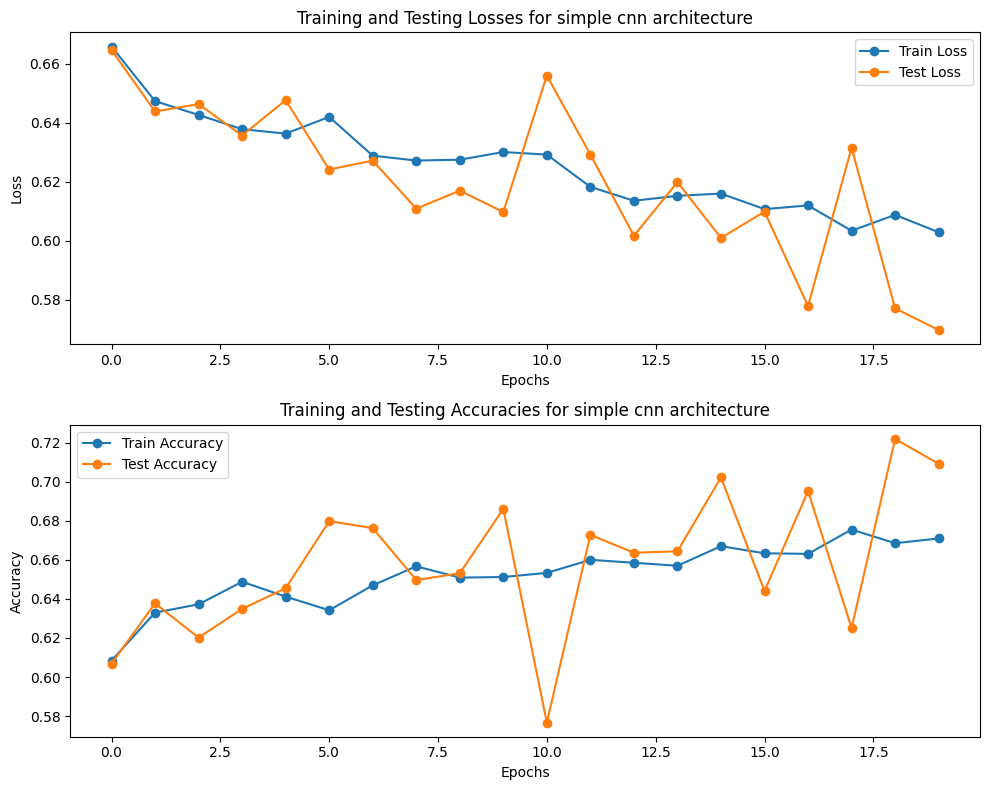

In [27]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(epochs, train_losses_simplecnn, label='Train Loss', marker='o')
ax1.plot(epochs, test_losses_simplecnn, label='Test Loss', marker='o')
ax1.set_title('Training and Testing Losses for simple cnn architecture')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, train_accuracies_simplecnn, label='Train Accuracy', marker='o')
ax2.plot(epochs, test_accuracies_simplecnn, label='Test Accuracy', marker='o')
ax2.set_title('Training and Testing Accuracies for simple cnn architecture')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()

plt.show()

In [8]:
# Resnet Model

class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        # Load the pre-trained ResNet-32 model
        self.resnet18 = models.resnet18(pretrained=True)
        
        # Modify the final fully connected layer to match the number of classes in your problem
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

# Create an instance of the ResNet32 model
resnet_model = ResNet18()

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Resnet Hyperparameters

resnet_num_epochs = 10
criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam([
    {'params': resnet_model.resnet18.conv1.parameters(), 'lr': 0.0001},
    {'params': resnet_model.resnet18.layer1.parameters(), 'lr': 0.0001},
    {'params': resnet_model.resnet18.layer2.parameters(), 'lr': 0.0001},
    {'params': resnet_model.resnet18.layer3.parameters(), 'lr': 0.0001},
    {'params': resnet_model.resnet18.layer4.parameters(), 'lr': 0.0001},
    {'params': resnet_model.resnet18.fc.parameters(), 'lr': 0.001},
], lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

train_losses_resnet = []
train_accuracies_resnet = []
test_losses_restnet = []
test_accuracies_resnet = []
epochs = range(resnet_num_epochs)

train_model(resnet_model, resnet_optimizer, resnet_num_epochs, train_losses_resnet, train_accuracies_resnet, test_losses_restnet, test_accuracies_resnet)

Epoch 0...
train Loss: 0.4497 Acc: 0.7966
val Loss: 0.1687 Acc: 0.9425
Epoch 1...
train Loss: 0.3755 Acc: 0.8361
val Loss: 0.2438 Acc: 0.9117
Epoch 2...
train Loss: 0.3310 Acc: 0.8585
val Loss: 0.1290 Acc: 0.9467
Epoch 3...
train Loss: 0.3226 Acc: 0.8652
val Loss: 0.1807 Acc: 0.9376
Epoch 4...
train Loss: 0.2919 Acc: 0.8701
val Loss: 0.1578 Acc: 0.9474
Epoch 5...
train Loss: 0.2943 Acc: 0.8761
val Loss: 0.2361 Acc: 0.9054
Epoch 6...
train Loss: 0.2998 Acc: 0.8780
val Loss: 0.1303 Acc: 0.9502
Epoch 7...
train Loss: 0.2748 Acc: 0.8822
val Loss: 0.1392 Acc: 0.9474
Epoch 8...
train Loss: 0.2629 Acc: 0.8895
val Loss: 0.1480 Acc: 0.9474
Epoch 9...
train Loss: 0.2604 Acc: 0.9010
val Loss: 0.1505 Acc: 0.9411


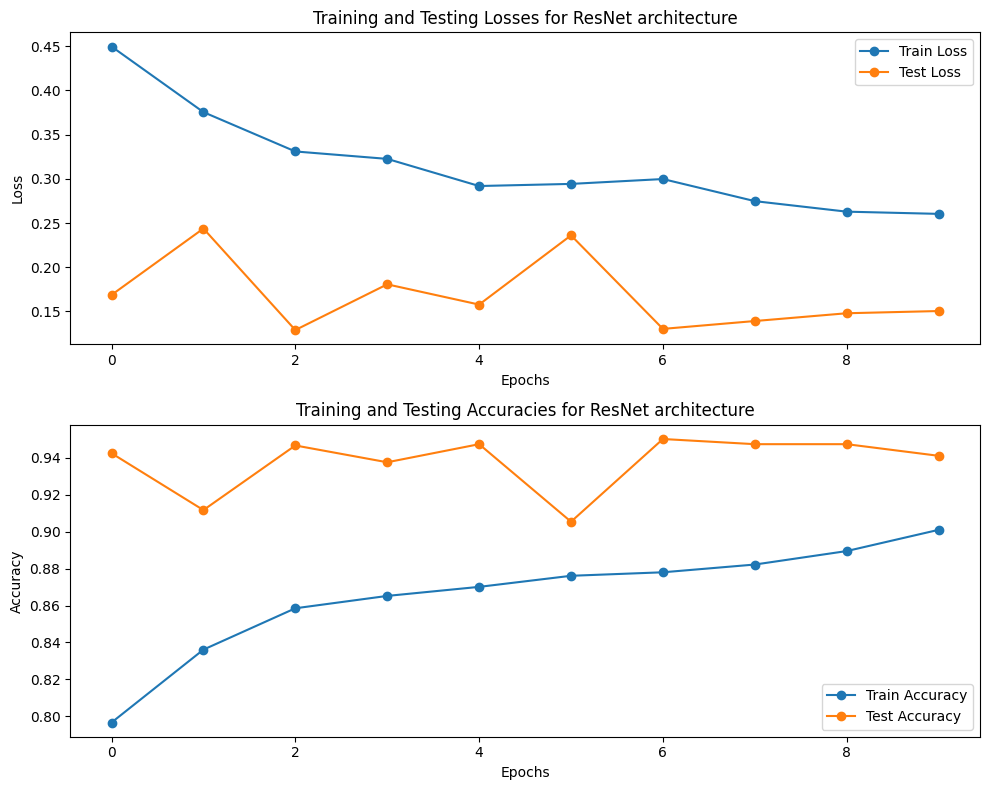

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(epochs, train_losses_resnet, label='Train Loss', marker='o')
ax1.plot(epochs, test_losses_restnet, label='Test Loss', marker='o')
ax1.set_title('Training and Testing Losses for ResNet architecture')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, train_accuracies_resnet, label='Train Accuracy', marker='o')
ax2.plot(epochs, test_accuracies_resnet, label='Test Accuracy', marker='o')
ax2.set_title('Training and Testing Accuracies for ResNet architecture')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()

plt.show()

In [10]:
# Shuffle Net Model

shufflenet_model = models.shufflenet_v2_x1_0(pretrained=True)
shufflenet_model.fc = nn.Linear(1024, 2)

shufflenet_model.to(device)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /Users/shubhambansal/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.79M/8.79M [00:00<00:00, 29.7MB/s]


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [11]:
shufflenet_optimizer = optim.Adam(shufflenet_model.parameters(), lr=0.001)
shufflenet_num_epochs = 10

train_losses_shufflenet = []
train_accuracies_shufflenet = []
test_losses_shufflenet = []
test_accuracies_shufflenet = []
epochs = range(shufflenet_num_epochs)

train_model(shufflenet_model, shufflenet_optimizer, shufflenet_num_epochs, train_losses_shufflenet, train_accuracies_shufflenet, test_losses_shufflenet, test_accuracies_shufflenet)

Epoch 0...
train Loss: 0.4713 Acc: 0.7772
val Loss: 0.2411 Acc: 0.8935
Epoch 1...
train Loss: 0.3971 Acc: 0.8203
val Loss: 0.1910 Acc: 0.9278
Epoch 2...
train Loss: 0.3786 Acc: 0.8355
val Loss: 0.2085 Acc: 0.9208
Epoch 3...
train Loss: 0.3701 Acc: 0.8379
val Loss: 0.1984 Acc: 0.9243
Epoch 4...
train Loss: 0.3758 Acc: 0.8349
val Loss: 0.1984 Acc: 0.9285
Epoch 5...
train Loss: 0.3421 Acc: 0.8509
val Loss: 0.1686 Acc: 0.9404
Epoch 6...
train Loss: 0.3449 Acc: 0.8427
val Loss: 0.1693 Acc: 0.9418
Epoch 7...
train Loss: 0.3331 Acc: 0.8512
val Loss: 0.1655 Acc: 0.9411
Epoch 8...
train Loss: 0.3325 Acc: 0.8564
val Loss: 0.1850 Acc: 0.9299
Epoch 9...
train Loss: 0.3243 Acc: 0.8579
val Loss: 0.1629 Acc: 0.9369


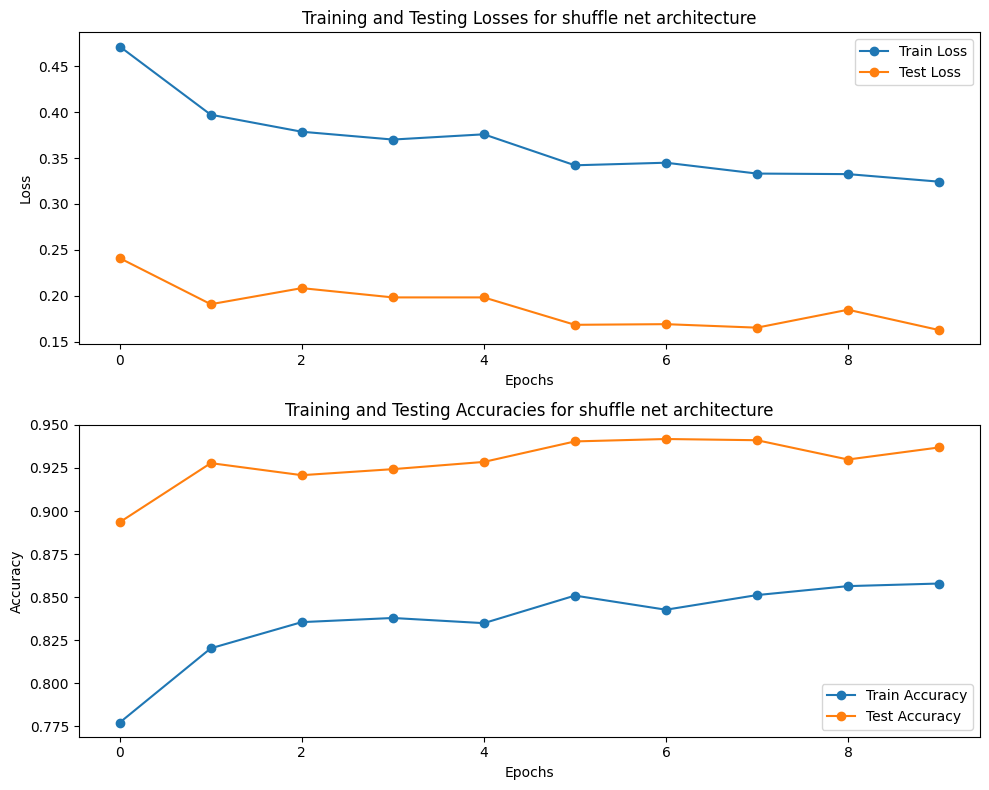

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(epochs, train_losses_shufflenet, label='Train Loss', marker='o')
ax1.plot(epochs, test_losses_shufflenet, label='Test Loss', marker='o')
ax1.set_title('Training and Testing Losses for shuffle net architecture')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, train_accuracies_shufflenet, label='Train Accuracy', marker='o')
ax2.plot(epochs, test_accuracies_shufflenet, label='Test Accuracy', marker='o')
ax2.set_title('Training and Testing Accuracies for shuffle net architecture')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()

plt.show()